In [3]:
import datetime
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import gmplot as gp
%matplotlib inline

def get_duration(battle):
    if battle.end_date == "None" or not battle.end_date or battle.end_date==battle.start_date:
        return 1
    else:
        return (datetime.datetime.strptime(battle.end_date, "%Y-%m-%d") - datetime.datetime.strptime(battle.start_date, "%Y-%m-%d")).days
    
def get_year(date):
    return datetime.datetime.strptime(date, "%Y-%m-%d").year if date else None

In [67]:
battles = pd.DataFrame([json.loads(line) for line in open("../datasets/battle-features-2.json")])

decades = range(1000, 2018+10, 10)
centuries = range(1000, 2018+100, 100)
halfcent  = range(1000, 2018+50, 50)
halfdec  = range(1000, 2018+5, 5)
battles["year"] = battles[battles.start_date.notnull()].start_date.apply(get_year)
battles["decade"] = pd.cut(battles["year"], decades, labels=decades[:-1])
battles["halfdec"] = pd.cut(battles["year"], halfdec, labels=halfdec[:-1])
battles["century"] = pd.cut(battles["year"], centuries, labels=centuries[:-1])
battles["halfcent"] = pd.cut(battles["year"], halfcent, labels=halfcent[:-1])

battles["duration"] = [get_duration(battle) for _, battle in battles.iterrows()]
battles["log_duration"] = np.log10(battles.duration)

battles.indecisive = ((battles.result_combatant_1 == "") & (battles.result_combatant_2 == "")) | battles.indecisive

battles.duration.quantile([.10, .5, .95])

0.10     1.0
0.50     1.0
0.95    89.0
Name: duration, dtype: float64

In [81]:
def plot_timeline(filename):
    battles_p = pd.DataFrame(battles[battles.start_date.notnull() & battles.year.between(from_year, to_year)])

    fig = plt.figure(figsize=(36, 8))
    dur = fig.add_subplot(111)
    twins = [dur.twinx(), dur.twinx(), dur.twinx()]
    count, ind, casp = twins

    dur.set_xlim(left=from_year, right=to_year)
    dur.set_xlabel("", fontsize=font_size, color=font_color)
    dur.tick_params(labelsize=font_size-8, labelcolor=font_color)
    dur.spines["left"].set_color(dur_color)
    dur.spines['left'].set_linewidth(3)
    dur.spines["top"].set_visible(False)
    dur.spines["right"].set_visible(False)
    dur.set_zorder(count.get_zorder()+1)
    dur.patch.set_visible(False)

    count.spines['left'].set_position(('outward', 35))
    count.spines["left"].set_visible(True)
    count.spines["left"].set_color(count_color)
    count.spines["left"].set_linewidth(5)
    count.spines["top"].set_visible(False)
    count.spines["right"].set_visible(False)
    count.yaxis.set_label_position('left') 
    count.yaxis.set_ticks_position('left')
    count.tick_params(labelsize=font_size, labelcolor=font_color)
    count.grid(linestyle="-")

    ind.spines['right'].set_position(('outward', 0))
    ind.spines['right'].set_linewidth(3)
    ind.spines['right'].set_color(ind_color)
    ind.spines["top"].set_visible(False)
    ind.set_ylim(bottom=0, top=100)
    ind.set_yticklabels([])

    casp.spines['right'].set_position(('outward', 3))
    casp.spines['right'].set_linewidth(3)
    casp.spines['right'].set_color(casp_color)
    casp.spines["top"].set_visible(False)
    casp.set_ylim(bottom=0, top=100)
    casp.tick_params(labelsize=font_size, labelcolor=font_color)

        
    if lineplot_groups == "decade":
        shift = 5
    elif lineplot_groups == "halfcent":
        shift = 25
    
    b_c = battles_p[count_groups].value_counts(sort=False)
    count.bar(np.array(b_c.index), np.array(b_c), width=barwidth, linewidth=1, color=count_color, edgecolor=[baredge_color]*len(b_c))

    b_d = battles_p[battles_p.duration < 90].groupby(lineplot_groups).duration.mean().dropna()
    dur_l = dur.plot(np.array(b_d.index)+shift, np.array(b_d), color=dur_color, linewidth=3, marker='v', markersize=10)

    b_i = (battles_p.groupby(lineplot_groups).indecisive.sum()/battles_p.groupby(lineplot_groups).title.count())*100
    ind_l = ind.plot(np.array(b_i.index)+shift, np.array(b_i), color=ind_color, linewidth=3, marker="o", markersize=10)

    battles_p["casp"] = ((battles_p.casualties_1 + battles_p.casualties_2)/(battles_p.strength_1+battles_p.strength_2))*100.0
    #battles_p["cas"] = battles_p.casualties_1 + battles_p.casualties_2
    clean = (battles_p.strength_1 >= battles_p.casualties_1) & (battles_p.strength_2 >= battles_p.casualties_2)
    #b_cas = battles_p[battles_p.cas > 0 & clean].groupby(lineplot_groups).cas.median()
    b_casp = battles_p[battles_p.casp.between(1, 100) & clean].groupby(lineplot_groups).casp.mean()
    
    casp_l = casp.plot(np.array(b_casp.index)+shift, np.array(b_casp), color=casp_color, linewidth=3, marker='o', markersize=10)

    if legend:
        lns = dur_l+ind_l+casp_l
        labs = ["Mean duration (days)", "Indecisive fraction (%)", "Mean casualties ratio (%)"]
        l = count.legend(lns, labs, loc=2, fontsize=font_size, facecolor=legend_color, framealpha=1)
        for text in l.get_texts():
            text.set_color(font_color)
    
    fig.savefig(filename, dpi=200, transparent=True, bbox_inches='tight')

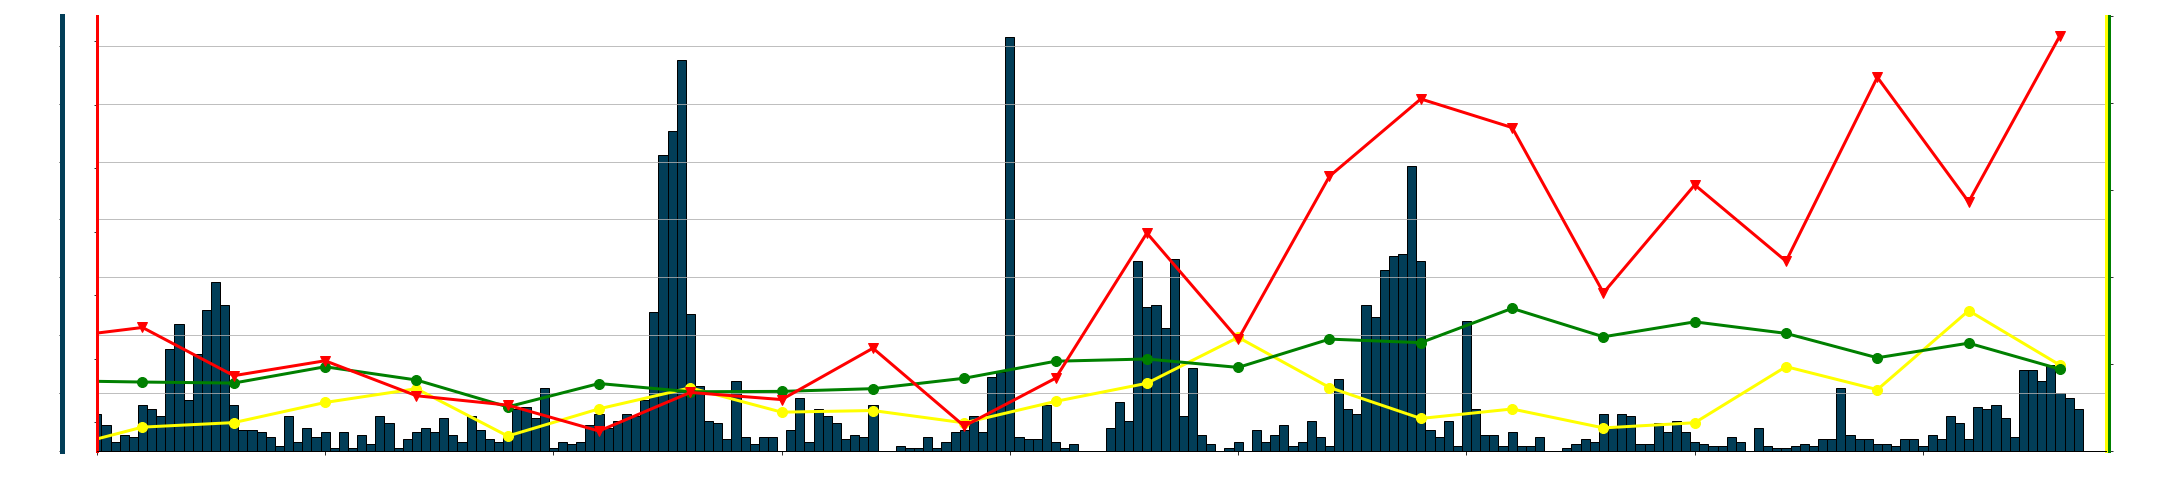

In [82]:
from_year=1800
to_year=2020

count_groups = "year"
barwidth = 1
lineplot_groups = "decade"
legend = False

count_color = "#023E58"
dur_color = "red"
ind_color = "yellow"
casp_color = "green"

baredge_color = "black"

font_size = 25
font_color = "white"

legend_color = "#0E1626"

plot_timeline("1800.png")

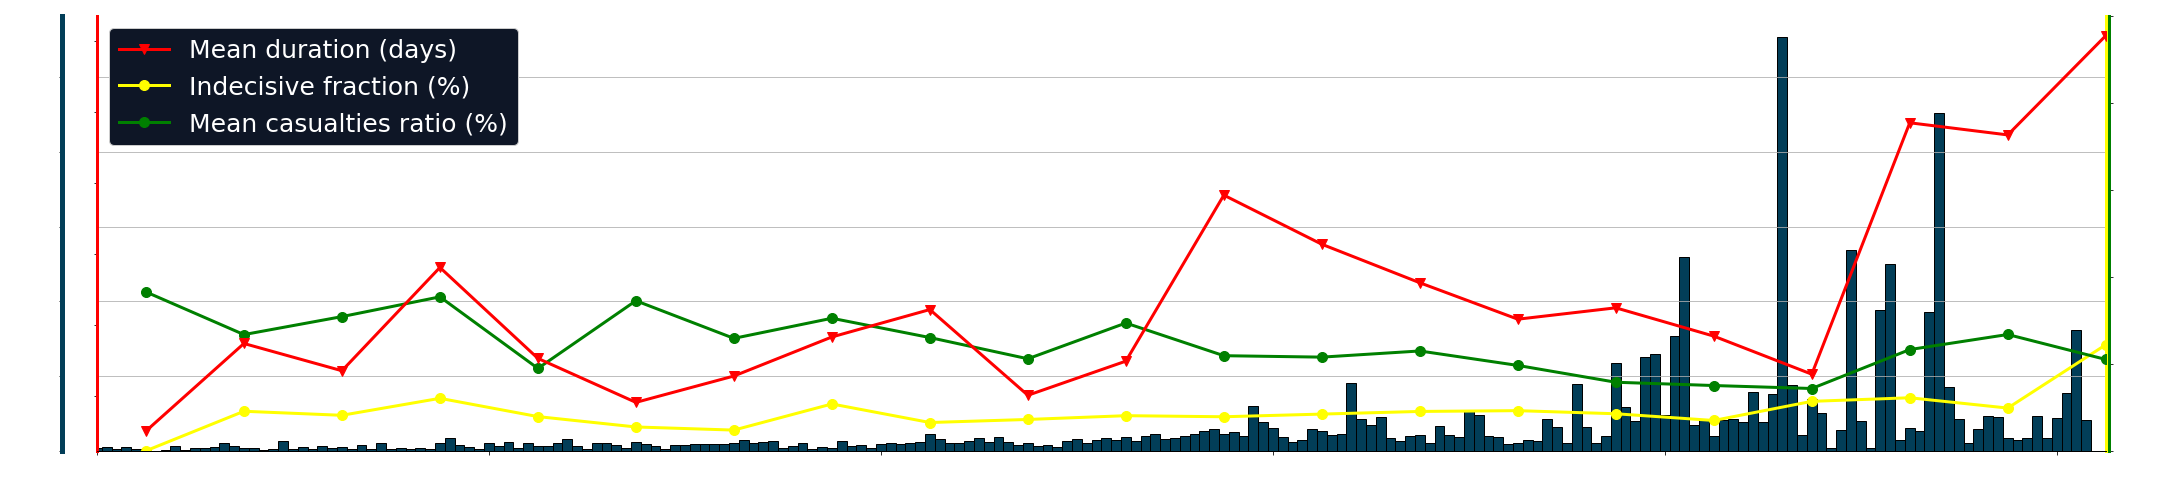

In [83]:
from_year=1000
to_year=2025

count_groups = "halfdec"
barwidth = 5
lineplot_groups = "halfcent"
legend = True

plot_timeline("1000.png")

In [47]:
for start, stop in zip(range(1000, 2000, 200), range(1200, 2018, 200)):
    coord_df = battles[battles.year.between(start, stop)][["latitude", "longitude"]].dropna()
    gmap = gp.GoogleMapPlotter(0,0,3)
    gmap.heatmap(coord_df.latitude, coord_df.longitude)
    gmap.draw("maps/%s-%s.html" % (start, stop))

In [9]:
#]1860,1866[ ; ]1913, 1919[; ]1938, 1946[; ]2000, infinity[
for start, stop in [(1861, 1866),(1914, 1918),(1939, 1945),(2001,2020)]:
    coord_df = battles[battles.year.between(start, stop)][["latitude", "longitude"]].dropna()
    gmap = gp.GoogleMapPlotter(0,0,3)
    gmap.heatmap(coord_df.latitude, coord_df.longitude)
    gmap.draw("maps/%s-%s.html" % (start, stop))

In [66]:
for start, stop in [(1861, 1866),(1914, 1918),(1939, 1945),(2001,2020)]:
    print(battles[battles.year.between(start, stop) & (battles.duration < 100)].duration.mean())

2.48263888889
8.90853658537
12.1385199241
13.0383275261
